<a href="https://colab.research.google.com/github/PromitHal/Pytorch/blob/master/CNN_Pytorch1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
import numpy as np
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader


In [7]:
dataset=MNIST(
    root='data/',
    download=True,
    transform=ToTensor()
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [8]:
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [17]:
img,label=dataset[0]
img.shape,label

(torch.Size([1, 28, 28]), 5)

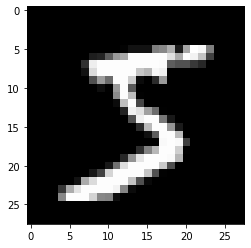

In [20]:
import matplotlib.pyplot as plt
img=img.reshape((28,28))
plt.imshow(img,cmap='gray')

Next, we define and use a function split_indices  to pick a random 20% fraction of the  images for the validation set

In [21]:
def split_indices(n,val_pct):
  n_val=int(val_pct*n)
  idxs=np.random.permutation(n)
  return idxs[n_val:],idxs[:n_val]

In [22]:
train_indices,val_indices=split_indices(len(dataset),val_pct=0.2)
print(len(train_indices),len(val_indices))

48000 12000


In [24]:
batch_size=100

#Train sampler
train_sampler=SubsetRandomSampler(train_indices)
train_dl=DataLoader(dataset,batch_size,sampler=train_sampler)
#Validation sampler
valid_sampler=SubsetRandomSampler(val_indices)
valid_dl=DataLoader(dataset,batch_size,sampler=valid_sampler)

**Model**

In [28]:
import torch.nn as nn
import torch.nn.functional as F
input_size=28*28
num_classes=10

In [33]:
class  MnistModel(nn.Module):
  def __init__(self,in_size,hidden_size,out_size):
    super().__init__()
    self.linear1=nn.Linear(in_size,hidden_size)
    self.linear2=nn.Linear(hidden_size,out_size)

  def forward(self,xb):
    #Flatten the image tensors
    xb=xb.view(xb.size(0),-1)
    #Get intermediate outputs using hidden layers
    out=self.linear1(xb)
    #Apply activation function
    out=F.relu(out)
    #Get predictions using output layer
    out=self.linear2(out)
    return out


In [34]:
input_size=784
num_classes=10
model=MnistModel(input_size,hidden_size=32,out_size=num_classes)

In [35]:
for t in model.parameters():
  print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [42]:
for images,labels in train_dl:
  print('images.shape',images.shape)
  outputs=model(images)
  loss=F.cross_entropy(outputs,labels)
  print('Loss:',loss.item())
  break
print('outputs.shape',(outputs.shape))


images.shape torch.Size([100, 1, 28, 28])
Loss: 2.3012070655822754
outputs.shape torch.Size([100, 10])


In [45]:
torch.cuda.is_available()

False

In [46]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [47]:
device=get_default_device()
device

device(type='cpu')

In [63]:
def to_device(data,device):
  if isinstance(data,(list,tuple)):
    return [to_device(x,device)for x in data ]
  return data.to(device,non_blocking=True)

In [64]:
for images,labels in train_dl:
  print(images.shape)
  images=to_device(images,device)
  print(images.device)
  break

torch.Size([100, 1, 28, 28])
cpu


In [55]:
len(train_dl)

480

Finally,we define a DeviceDataLoader class to wrap our existing data loaders and move data to the selected device, as  batches are accessed.Interestinly,we dont need to extend an existing class to create a PyTorch dataloader. All we need is an __iter__ method to retrieve batches of data, and an __len__ method to get the number of batches


In [51]:
class DeviceDataLoader():
  '''Wrap a dataloader to move data into a device'''
  def __init__(self,dl,device):
    self.dl=dl
    self.device=device
  def __iter__(self):
    '''Yield a batch of data after moving it into a device'''
    for b in self.dl:
      yield to_device(b,self.device)
  def __len__(self):
    '''Number of batches'''
    return len(self.dl)

In [52]:
train_dl=DeviceDataLoader(train_dl,device)
valid_dl=DeviceDataLoader(valid_dl,device)

In [ ]:
for xb,yb in valid_dl:
  print('xb.device',xb.device)
  print(yb)

In [67]:
def loss_batch(model,loss_func,xb,yb,opt=None,metric=None):
  #Generate predictions
  preds=model(xb)
  #Calculate loss
  loss=loss_func(preds,yb)
  if opt is not None:
    #Compute gradients
    loss.backward()
    #Update parameters
    opt.step()
    #Reset gradients
    opt.zero_grad()

  metric_result=None
  if metric is not None:
    #Compute the metric
    metric_result=metric(preds,yb)
  return loss.item(),len(xb),metric_result
  


In [58]:
def evaluate(model,loss_fn,valid_dl,metric=None):
  with torch.no_grad():
    #Pass each batch through the model
    results=[loss_batch(model,loss_fn,xb,yb,metric=metric)]
    losses,nums,metrics=zip(*results)
    total=np.sum(nums)
    avg_loss=np.sum(np.multiply(losses,nums))/total
    avg_metric=None
    if metric is not None:
      avg_metric=np.sum(np.multiply(metrics,nums))/total
    return avg_loss,total,avg_metric

In [59]:
def fit(epochs,lr,model,loss_fn,train_dl,valid_dl,metric=None,opt_fn=None):
  losses,metrics=[],[]
  #Instantiate the optimizer
  if opt_fn is None: opt_fn=torch.optim.SGD
  opt=opt_fn(model.parameters(),lr=lr)

  for epoch in range(epochs):
    #Training
    for xb,yb in train_dl:
      loss_batch(model,loss_fn,xb,yb,opt)
    #Evaluation
    result=evaluate(model,loss_fn,valid_dl,metric)
    val_loss,total,val_metric=result

    losses.append(val_loss)
    metrics.append(val_metric)

    if metric is None:
      print('Epoch[{}/{}],Loss {:.4f}'.format(epoch+1,epochs,val_loss))
    else:
      print('Epoch[{}/{}],Loss{:.4f},{}:{:.4f}'.format(epoch+1,epochs,val_loss,metric.__name__,val_metric))
  return losses,metrics


In [60]:
def accuracy(outputs,labels):
  _,preds=torch.max(outputs,dim=1)
  return torch.sum(preds==labels).item()/len(preds)

In [65]:
model=MnistModel(input_size,hidden_size=32,out_size=num_classes)
to_device(model,device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [68]:
val_loss,total,val_acc=evaluate(model,F.cross_entropy,valid_dl,metric=accuracy)
print('Loss:{:.4f},Accuracy:{:.4f}'.format(val_loss,val_acc))

Loss:2.2847,Accuracy:0.1500


In [69]:
losses1,metrics1=fit(5,0.5,model,F.cross_entropy,train_dl,valid_dl,accuracy)

Epoch[1/5],Loss0.3199,accuracy:0.9400
Epoch[2/5],Loss0.2611,accuracy:0.9100
Epoch[3/5],Loss0.2552,accuracy:0.9300
Epoch[4/5],Loss0.2367,accuracy:0.9300
Epoch[5/5],Loss0.1380,accuracy:0.9400


In [72]:
losses2,metrics2=fit(5,0.01,model,F.cross_entropy,train_dl,valid_dl,accuracy)

Epoch[1/5],Loss0.1635,accuracy:0.9400
Epoch[2/5],Loss0.1640,accuracy:0.9400
Epoch[3/5],Loss0.1645,accuracy:0.9400
Epoch[4/5],Loss0.1645,accuracy:0.9400
Epoch[5/5],Loss0.1659,accuracy:0.9400


Text(0.5, 1.0, 'Accuracy vs No. of epochs')

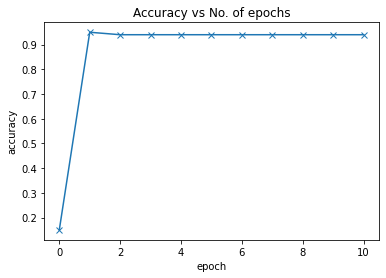

In [73]:
import matplotlib.pyplot as plt
accuracies=[val_acc]+metrics1+metrics2
plt.plot(accuracies,'-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs No. of epochs')